# SNOTEL exploratory visualization notebook
*J. Michelle Hu  
University of Utah  
June 2024*  
---

In [1]:
import sys
import xarray as xr
import numpy as np

from pathlib import PurePath
import pandas as pd
import hvplot.xarray
import rioxarray as riox
import matplotlib.pyplot as plt

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')

import helpers as h

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/work/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Directory

In [2]:
basin = 'blue'

In [3]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
basindir = h.fn_list(workdir, f'*{basin}*')[0]

# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
days = h.fn_list(basindir, "*/*/run*/")

snotel_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL'

## Point comparison (SNOTEL)

~/git_dirs/isnoda/scripts/Snotel/get_snotelPoR_csv.sh  
Living in /uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL

In [4]:
snotelfn = h.fn_list(snotel_dir, '*415*csv')[0]
snotelfn

'/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/20240621_PoR_site415.csv'

In [5]:
df = pd.read_csv(snotelfn, skiprows=63, usecols=list(np.arange(0, 7)), parse_dates=["Date"])
# Copy date to new date indexing column
df['DateIndex'] = df['Date']

# reset index as Date
df = df.set_index('DateIndex')
df

,Date,Copper Mountain (415) Snow Depth (cm) End of Day Values,Copper Mountain (415) Snow Water Equivalent (mm) End of Day Values,Copper Mountain (415) Snow Density (pct) End of Day Values,Copper Mountain (415) Wind Speed Average (km/hr),Copper Mountain (415) Air Temperature Observed (degC) End of Day Values,Copper Mountain (415) Precipitation Increment (mm)
DateIndex,,,,,,,
1978-10-01,1978-10-01,NaN,0.0,NaN,NaN,NaN,0.0
1978-10-02,1978-10-02,NaN,0.0,NaN,NaN,NaN,0.0
1978-10-03,1978-10-03,NaN,0.0,NaN,NaN,NaN,0.0
1978-10-04,1978-10-04,NaN,0.0,NaN,NaN,NaN,0.0
1978-10-05,1978-10-05,NaN,0.0,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...
2024-06-16,2024-06-16,0.0,0.0,NaN,NaN,6.9,0.0
2024-06-17,2024-06-17,0.0,0.0,NaN,NaN,9.8,0.0
2024-06-18,2024-06-18,0.0,0.0,NaN,NaN,4.2,0.0


## TODO: Get site name and number to properly pull shortname

### Period of Record

Snow Depth (cm
Snow Water Equivalent (mm
Snow Density (pct
Wind Speed Average (km/hr)
Air Temperature Observed (degC
Precipitation Increment (mm)


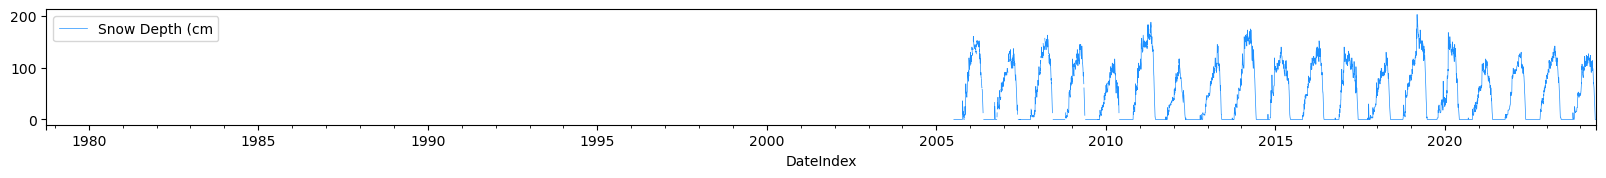

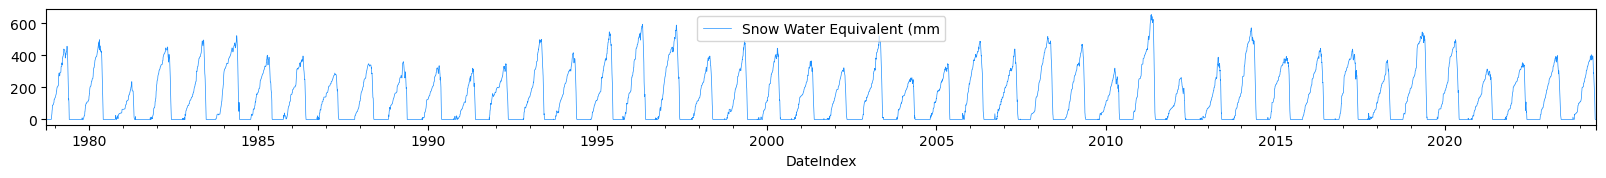

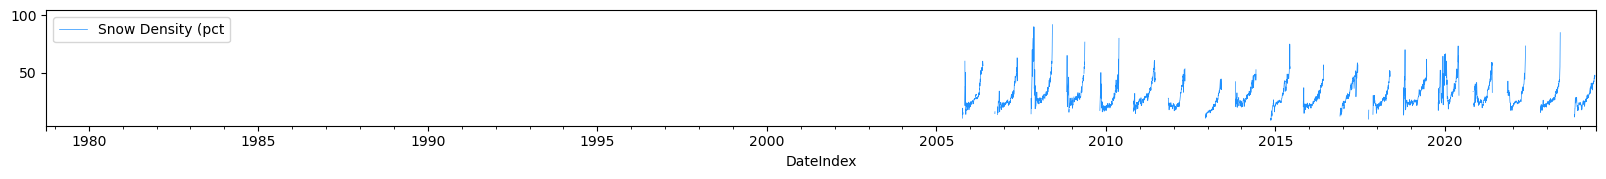

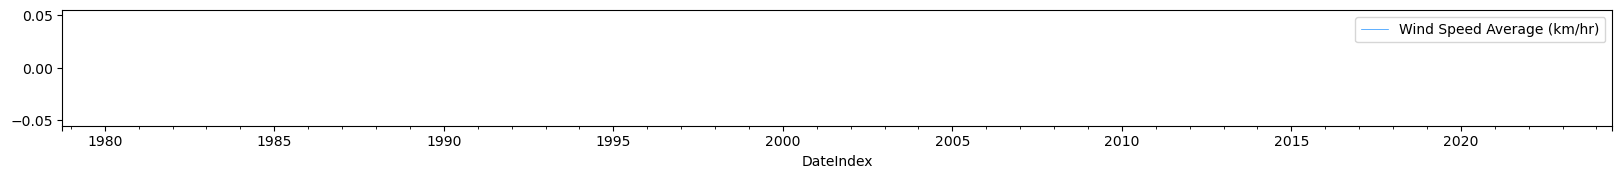

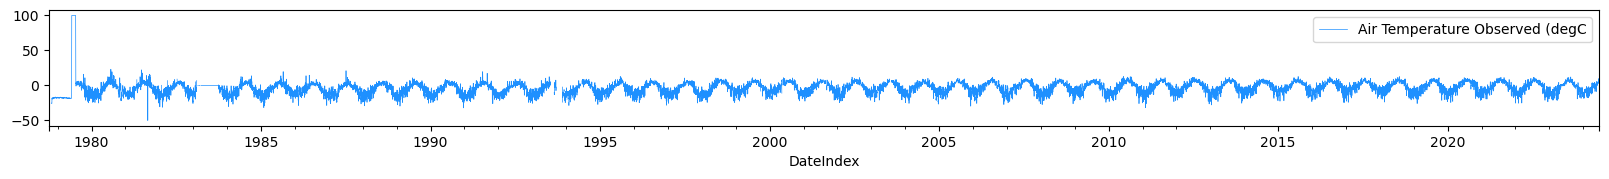

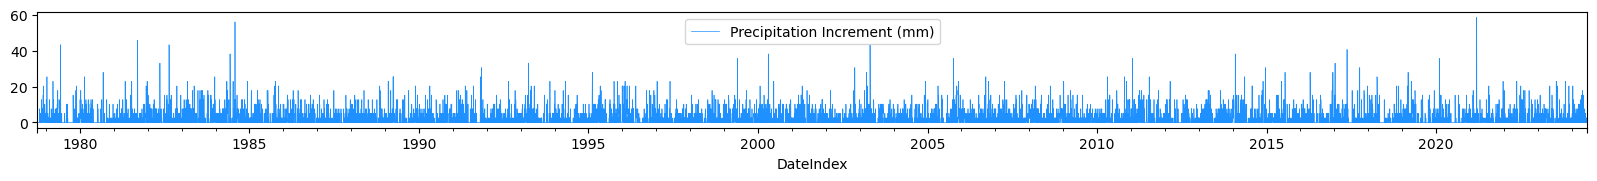

In [6]:
# Plot snotel bits
linestyle = '-' #':'
linewidth = 0.5
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']

# Plot full time series
for colname in df.columns[1:]:
    figsize = (20, 1.5)
    fig, ax = plt.subplots(figsize=figsize)

    shortname = colname.split(') ')[1]
    shortname = shortname.split(' End of Day Values')[0]
    print(shortname)
    df[colname].plot(ax=ax, label=shortname, linestyle=linestyle, linewidth=linewidth, color=snotelcolors[0], marker=marker)
    plt.legend();

### Specified WY 

In [7]:
# Plot for the water year of interest
WY = int(days[0].split('wy')[1].split('/')[0])

# Clip
snotel_df = df[(df['Date']>=f'{WY - 1}-10-01') & (df['Date']<f'{WY}-10-01')]

Snow Depth (cm
Snow Water Equivalent (mm
Snow Density (pct
Wind Speed Average (km/hr)
Air Temperature Observed (degC
Precipitation Increment (mm)


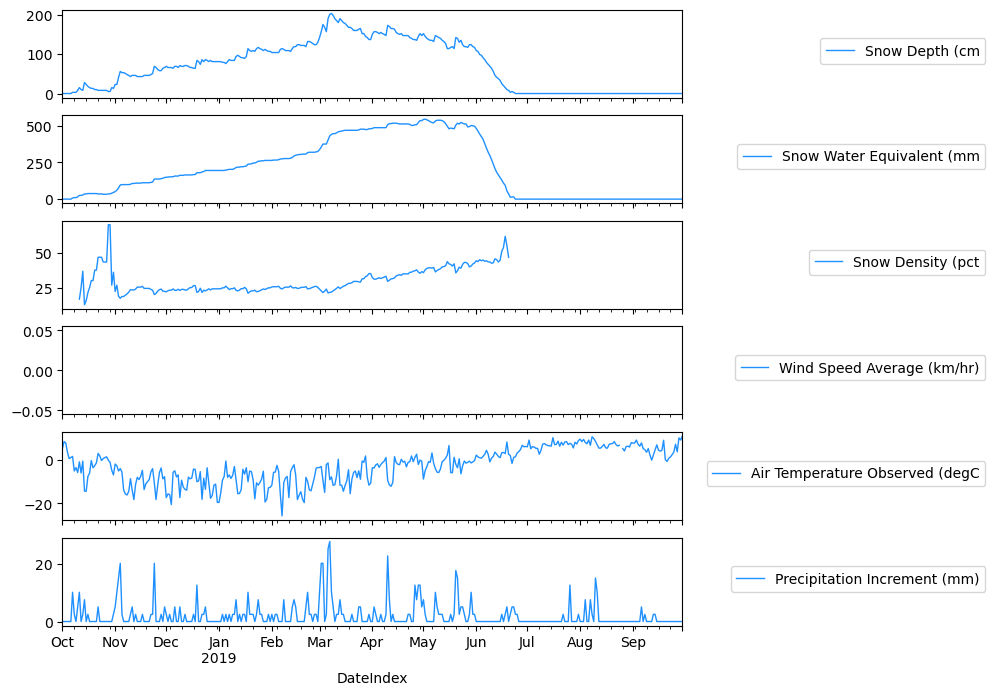

In [8]:
# Plot snotel bits
linestyle = '-' #':'
linewidth = 1
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']

# Plot full time series
figsize = (8, 8)
fig, axa = plt.subplots(len(df.columns[1:]), 1, figsize=figsize, sharex=True)
for jdx, colname in enumerate(df.columns[1:]):
    # Extract data variable label
    shortname = colname.split(') ')[1]
    shortname = shortname.split(' End of Day Values')[0]
    print(shortname)
    
    ax = axa.flatten()[jdx]
    snotel_df[colname].plot(ax=ax, label=shortname, linestyle=linestyle, linewidth=linewidth, color=snotelcolors[0], marker=marker)
    ax.legend(loc='upper right', bbox_to_anchor=(1.5, 0.75), alignment='center');